<h3>Research Notebook for term paper 2022</h3>
<p>Development and research done by <b>Mihail Mironov BEC-191</b> under the supervision and guidence of <b>E.A.Yanovsky</b></p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch 

from ipywidgets import IntProgress

<h3>Introduction</h3>
<p>In this notebook is my though process that lead me to some intersting results. Unfortunately, I dont have any data to test proposed algorithms properly so I resorted to using sythetic data sampled from various distributions (about this later in the notebook).</p>

<h3>Design of data</h3>
<p>In the following sections we are going to sample players' preferences as well as advertisements. These will be represented by boolean vectors with each input representing exactly one topic: if values is True or 1 it implies that a given person likes this topic or in the content of advetisement given ad covers this topic and everything is opposite when the value is 0. So everything is clean and simple.</p>

<h3>Get a group of targeted individuals</h3>
<p>Since I have no real data I use synthetic data to run calculations. In order to mimic reality I sample data from various distributions at once. Such decision can be explained in the following way: younger people are more likely to google things related to tech than elderly (at least I think so). So for every subgroup of people with some special characteristic endowed to them there is their own distribution of preferences. Such distributions could be drawn from real data if I had some.</p>

<p>Let's say that we have 20 subgroups of people based on age, sex, time and space based characteristics and etc.</p>

In [2]:
class Group:
    
    def __init__(self, n_players, n_topics):
        self.n_players = n_players
        self.n_topics = n_topics
        self._weights = None
       
    @property
    def weights(self):
        return self._weights
    
    @weights.setter
    def weights(self, weights):
        assert self.n_players == len(weights), "You need to pass in weight for every single player!!"
        self._weights = weights
        print(f"--- This weights will be used to weight preferences of players in the algorithm")
        
    def create_random_weights(self):
        self._weights = np.random.random((self.n_players, 1))
    
    # Vertical and horizontal partitioning at the same time
    def discrete_prefs(self, return_probs=False, specify_subgroups=None, n_subgroups=1):
        
        # Specify subgroups allows to pass in list of tuples with each tuple representing descrete 
        # pdf of every subgroup. Values in such tuple correspond to each topic's probability of being 
        # favoured by the member of a given subgroup. By default there is only one default subgroup with
        # random probabilities.
        
        if specify_subgroups is None:
            subgroups = [np.random.random(self.n_topics) for _ in range(n_subgroups)]
        else:
            subgroups = specify_subgroups

        prefs = None
        VALUES = [0, 1]
        
        for i, spec in enumerate(subgroups):
            
            assert len(spec) == self.n_topics, ("Each topic must be provided with its own probaility!!")
            
            div, mod = divmod(self.n_players, len(subgroups))
            batch_size = div if i != len(subgroups)-1 else div + mod
            # for each topic sample value for every member of subgroup
            batch_prefs = None
            
            # Columnwise 
            for topic_prob in spec:
                probabilities = [1-topic_prob, topic_prob] # P("0"), P("1")
                topic_prefs = np.random.choice(VALUES, size=(batch_size, 1), p=probabilities)
                
                if batch_prefs is None:
                    batch_prefs = topic_prefs
                else:
                    batch_prefs = np.hstack([batch_prefs, topic_prefs])
            
            # Row-wise
            if prefs is None:
                prefs = batch_prefs
            else:
                prefs = np.vstack([prefs, batch_prefs])
        
        if return_probs:
            return prefs, subgroups
        else:
            return prefs
        
        
    # vertical partitioning    
    def vertical_discrete_prefs(self, n_subgroups=1):
        
        VALUES = [0, 1]
        prefs = None
        
        for i in range(n_subgroups):

            div, mod = divmod(self.n_players, n_subgroups)
            batch_size = div if i != n_subgroups-1 else div + mod
            prob = np.random.random()
            probabilities = [1-prob, prob]
            
            subgroup_prefs = np.random.choice(VALUES, (batch_size, self.n_topics), p=probabilities)
            if prefs is None:
                prefs = subgroup_prefs
            else:
                prefs = np.vstack([prefs, subgroup_prefs])
            
        return prefs

<p><b>specify_subgroups</b> parameter allows to break the group down into subgroups with own topic probabilities.
In our test case we have the first group member of which like topic "1" with probability of 1 and topic "2" with probability of 0.1 (most likely they dont like it) same with group 2</p>
<p><b>n_subgroups allows</b> to control how many default random subgroups we want to get</p>

<h4>Test Case</h4>

In [3]:
np.random.seed(12)

In [4]:
test_group = Group(n_players=10, n_topics=2)

prefs, probs = test_group.discrete_prefs(return_probs=True, specify_subgroups=[(1, 0.1), (0.2, 0.3)])

# Generated preferences
prefs

array([[1, 1],
       [1, 1],
       [1, 0],
       [1, 1],
       [1, 0],
       [0, 0],
       [0, 0],
       [1, 0],
       [1, 1],
       [0, 0]])

In [5]:
# Probabilities used
probs

[(1, 0.1), (0.2, 0.3)]

<h4>Get a set of players</h4>

In [6]:
group = Group(n_players=100, n_topics=1000)

prefs = group.vertical_discrete_prefs(n_subgroups=20) # for some reason more volatile data
prefs

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 1, 1, ..., 0, 1, 1],
       [1, 0, 1, ..., 1, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

<h3>Get a pool of advertisements</h3>
<p>Each advertisemt is modelled the same way as players' preferences. But in this case each input of a boolean vector decides if a given advertisement covers the topic or not.</p>

In [7]:
class Pool:
    
    def __init__(self, n_ads, n_topics):
        self.n_ads = n_ads
        self.n_topics = n_topics # must match the number of topics in the preference set

    @property
    def norm_ads(self):
        return np.random.normal(loc=0.5, scale=0.166, size=(self.n_ads, self.n_topics)).round()

In [8]:
pool = Pool(n_ads=200, n_topics=1000)
ads = pool.norm_ads
ads

array([[1., 1., 1., ..., 0., 1., 0.],
       [0., 1., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 1., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 1., 0.],
       [1., 1., 1., ..., 0., 1., 1.]])

<h3>Common Utility Class **SKIP**</h3>

In [9]:
class ExclusionAlgoUtility:
    
    def plot_results(self, use_fields=['rho_score', 'ad_idx'], figsize=(8,6)):
        assert "results" in dir(self), "You must run the model first. Model.results is not defined yet!!"
        
        fig, subplots = plt.subplots(nrows=len(use_fields), ncols=1, sharex=True)
        subplots = [subplots] if len(use_fields) == 1 else subplots
        x_axis = range(1, self._n_players)
        
        fig.set_size_inches(*figsize) 
        fig.set_dpi(75)
        
        for ax, field in zip(subplots, use_fields):
            if isinstance(field, list):
                ax.plot(x_axis, *[self.results[subfield] for subfield in field])
                ax.legend(field)
                ax.set_ylabel(" & ".join(field))
            else:
                ax.plot(x_axis, self.results[field])
                ax.set_ylabel(field)
        
        subplots[-1].set_xlabel("Exclusion Step")
        plt.show()
        
    # takes list of callables as an input each must receive model.results object as an input    
    def plot_calculated_fields(self, modifier_funcs, figsize=(16, 12) ,attach_to=None):
        
        fig, subplots = plt.subplots(nrows=len(modifier_funcs), ncols=1, sharex=True)
        subplots = [subplots] if len(modifier_funcs) == 1 else subplots
        x_axis = range(1, self._n_players)
        
        fig.set_size_inches(*figsize)
        fig.set_dpi(75)
        
        for func, ax in zip(modifier_funcs, subplots):
            plot_data = func(self.results)
            ax.plot(x_axis, plot_data)
            
        subplots[-1].set_xlabel("Exclusion Step")
        plt.show()

<h2>Exclusion Algorithm</h2>
<h4>General Idea</h4>
<p>There are two sets of agents: <b>target set</b> - set of people that are targeted with an ad and <b>exclusion set</b> - people removed from target set that are to some extent not considered when making an ad recommendation. Algorithm runs until there is no one left in the target set. At each step only one agent is removed (later to be changed) according to weighted score. This score is calculated for each person at every single iteration. Agent that yields the highest score is excluded and assigned to exclusion set.</p>

<h4>Rho Score calculation</h4>
<br>
$
    \rho_{score}^{(i)} = \frac{1}{|Target\,/\,{X_j}|} \times \sum_{X_i\in{\,Target\,/\,{X_j}}}{\frac{<X_i\cdot A>}{<A\cdot A>}}\cdot{\alpha}+ \frac{1}{|Exclusion\,\cup{X_j}|} \times \sum_{X_i\in{\,Exclusion\,\cup{X_j}}}{\frac{<X_i\cdot A>}{<A\cdot A>}}\cdot{(1-\alpha)} \rightarrow \max_{X_i, A}
$
<br><br>
T - target set, E - exclusion set, X<sub>j</sub> - exclusion<br>
<h4>Algorithm</h4>
<p>Now it bruteforces through every single pair of (X<sub>i</sub> A) to find optimal solution (later to be changed). </p>
<p>Algotithm works as follows:</p>
<p>Repeat steps from below till there is no one in target set:</p>
<ul>
    <li>
        for each person in target set do:
        <ol>
            <li>Remove person from target set and put him into exclusion set</li>
            <li>Find the best ad according to the abovementioned metric</li>
            <li>Return removed person from exclusuon set to target one</li>
        </ol>
    </li>
    <li>find exlusion with highest score and move this person pernamently to exclusion set</li>
</ul>
<h4>Important to mention</h4>
<p>We use dot product of A (advirtisement) to itself to prevent advirtisers from describing their ads as if they cover mutliple topics because such ads will score lesser results</p>
<h4>Vectorized Calculations</h4>
<br>
$
dot\_array\,=\,<A\cdot A>\,=\,diag(A\cdot A^{T})\\
\rho_{score}^{(i)} = \alpha \cdot avg(\,\frac{Target\cdot A^{T}}{<A\cdot A>}\,) + (1-\alpha) \cdot avg(\,\frac{Exclusion\cdot A^{T}}{<A\cdot A>}\,)
$

In [10]:
class ExclusionAlgo(ExclusionAlgoUtility):
    
    def __init__(self, prefs, ads, weights=None):
        
        super().__init__()
        
        self.prefs = self._convert_to_cuda(prefs)
        self.ads = self._convert_to_cuda(ads)
        
        self._target_weight = 0.9
        self._n_players = len(self.prefs)
        self._n_ads = len(self.ads)
        self._dot_array = torch.einsum("ij,ij->i", self.ads, self.ads) #<A;A>
        self._target_idx = list(range(0, len(self.prefs)))
        self._excl_idx = []
        self._ALL = range(0, len(self.ads))
        
        if weights is None:
            self._weights = torch.ones(size=(self._n_players, 1)).cuda() 
        else:
            self._weights = self._convert_to_cuda(weights)
        
        
    def _convert_to_cuda(self, data):
        # to_double() to avoid weird error of addmm_cuda not implemented for ints. Seems CUDA doesnt work with ints
        return torch.from_numpy(data).cuda().double() 
        
    @property
    def available_fields(self):
        fields = ["rho_score", "ad_idx", "target_score", "excl_score", "excl_idx"]
        print("Model provides you with:\n" + "\n".join(fields))
        
        
    @property
    def target_weight(self):
        return self._target_weight
    
    @target_weight.setter
    def target_weight(self, weight):
        self._target_weight = weight
        print(f"---- By setting this weight you give {weight} importance to target group ----") 
        
    def calc_rho_score(self, target_idx, excl_idx, ad_idx=None):

        ad_idx = self._ALL if not ad_idx else [ad_idx] # if none indecies passed in then use all ads
        
        def rho_score(pref_idx, ad_idx):
            if len(pref_idx) > 0:
                X_A = torch.matmul(self.prefs[pref_idx], self.ads[ad_idx].T) / self._dot_array[ad_idx]
                wX_A = torch.mul(X_A, self._weights[pref_idx])
                return torch.sum(wX_A, axis=0) / torch.sum(self._weights[pref_idx])
            else:
                return torch.zeros(self._n_ads).cuda()
        
        target_scores = rho_score(target_idx, ad_idx)
        excl_scores = rho_score(excl_idx, ad_idx)
        
        rho_scores = self.target_weight * target_scores + (1 - self.target_weight) * excl_scores
        return rho_scores, target_scores, excl_scores
    
    
    # find best advertisement according to rho score
    def find_best_ad(self, target_idx, excl_idx, ad_idx=None):
        
        rho_scores, target_scores, excl_scores = self.calc_rho_score(target_idx, excl_idx, ad_idx)
        best_ad_idx = torch.argmax(rho_scores)
        best_rho_score = rho_scores[best_ad_idx]
        best_target_score, best_excl_score = target_scores[best_ad_idx], excl_scores[best_ad_idx]
        
        return [
            best_rho_score.item(), best_ad_idx.item(), best_target_score.item(), best_excl_score.item()
        ]
    
    
    def find_best_exclusion(self, target_idx, excl_idx):
        tmp_target_idx, tmp_excl_idx = target_idx.copy(), excl_idx.copy()
        
        exclusion_data = {
            'rho_score': [], 
            'ad_idx': [], 
            'target_score': [], 
            'excl_score': [], 
            'excl_idx': []
        }
        
        for i, idx in enumerate(target_idx):
            
            tmp_target_idx.remove(idx)
            tmp_excl_idx.append(idx)
            res = self.find_best_ad(tmp_target_idx, tmp_excl_idx) + [idx]
            
            for key, val in zip(exclusion_data.keys(), res):
                exclusion_data[key].append(val)
            tmp_target_idx.append(idx)
            tmp_excl_idx.remove(idx)
            
        rel_idx = np.array(exclusion_data['rho_score']).argmax()
        return [val[rel_idx] for val in exclusion_data.values()]
    
    def fit(self):
        
        tmp_target_idx, tmp_excl_idx = self._target_idx.copy(), self._excl_idx.copy()
        
        results = {
            'rho_score': [], 
            'ad_idx': [], 
            'target_score': [],
            'excl_score': [], 
            'excl_idx': []
        }
        
        excl_bundle = []
        
        progress = IntProgress(min=1, max=self._n_players, value=0, every=1)
        display(progress)
        start_idx = 0
        
        for i in range(self._n_players-1):
            res = self.find_best_exclusion(tmp_target_idx, tmp_excl_idx)

            for key, val in zip(results.keys(), res):
                results[key].append(val)
                
            excl_idx = res[-1]
            
            tmp_target_idx.remove(excl_idx)
            tmp_excl_idx.append(excl_idx)
            
            progress.value += 1

        model.results = results

In [11]:
model = ExclusionAlgo(prefs, ads)
model.target_weight = 0.9
model.fit()

---- By setting this weight you give 0.9 importance to target group ----


IntProgress(value=1, min=1)

In [12]:
model.available_fields

Model provides you with:
rho_score
ad_idx
target_score
excl_score
excl_idx


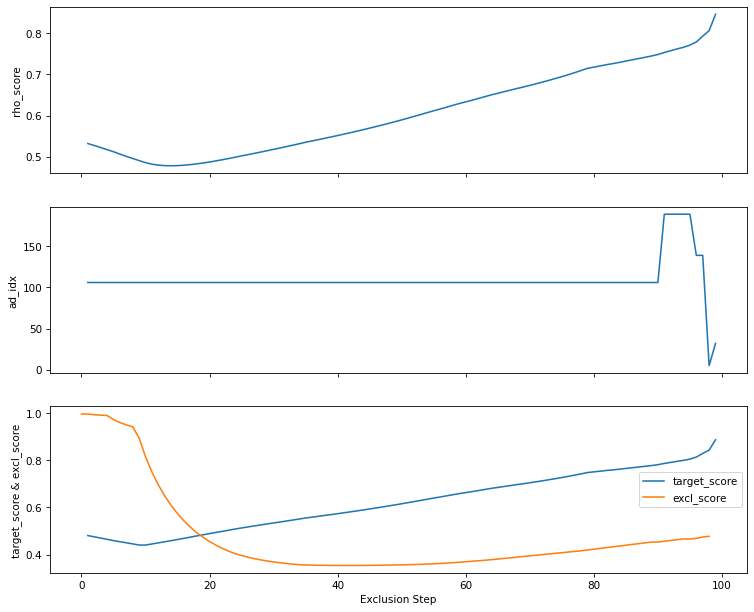

In [13]:
model.plot_results(use_fields=["rho_score", "ad_idx", ["target_score", "excl_score"]], figsize=(12,10))

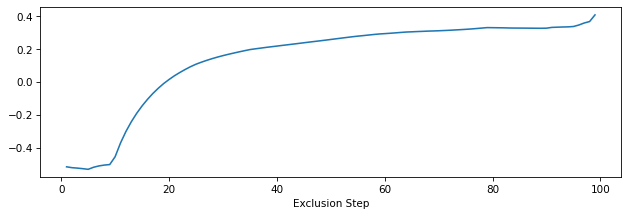

In [14]:
diff = lambda data: np.array(data['target_score']) - np.array(data['excl_score'])

model.plot_calculated_fields([diff], figsize=(10, 3))

<h3>Discussing obtained results</h3>
<p>Now we are to interpret graphs above. You can see that as we start the process of exclusion our rho_score seems to go down. This is mainly attributed to excl_score going down tremendously and target_score growing ever so slightly. If we dont contstraint exclusions we arrive at the situation where people in exclusion set are better off than ones in target which is definately not the intended behaviour. This happens mainly because at first exclusions excl_set is not that messy and it's better for algorithm in terms of rho_score to adapt itself to preferences of people in exclusion set. As we get more and more exclusions target set purifies itself from outliers on the other hand exclusion set is becoming more scattered across. At some point exclusion and target scores will switch places but this could be too late as people that actually belong in the target set are already excluded. So such division might be flawed that is why we introduced new important change to the algorithm.</p>

<p><b>Let's introduce constraint that bans exclusions resulting in target score being lower than exclusion score</b></p>

<h2>ExclusionConstrained</h2>


<h4>Rho Score calculation</h4>
<br>
$
    \rho_{score}^{(i)} = \frac{1}{|Target\,/\,{X_j}|} \times \sum_{X_i\in{\,Target\,/\,{X_j}}}{\frac{<X_i\cdot A>}{<A\cdot A>}}\cdot{\alpha}+ \frac{1}{|Exclusion\,\cup{X_j}|} \times \sum_{X_i\in{\,Exclusion\,\cup{X_j}}}{\frac{<X_i\cdot A>}{<A\cdot A>}}\cdot{(1-\alpha)} \rightarrow \max_{X_i, A}
$ <br><br>
$
st. \rho_{target}(Target\,/X_{j}, A) > \rho_{exclusion}(Exclusion\,\cup{X_j}, A)
$
<br>

In [15]:
class ExclusionConstrained(ExclusionAlgo):
    
    def __init__(self, prefs, ads, weights=None):
        super().__init__(prefs, ads, weights)
        
    # Implement interface  
    
    # We aim to find rho maximizing exclusion that yields target score no less than exclusion set
    # Previously there was a flaw with this as initial exclusions used to benefit exclusion set more which is 
    # definately unintended behaviour of the algorithm. Here we aim to fix this issue by allowing only exclusions
    # that result in target_score >= exclusion_score with rho_score maxed out.
    
    def find_best_exclusion(self, target_idx, excl_idx):
        tmp_target_idx, tmp_excl_idx = target_idx.copy(), excl_idx.copy()
        
        exclusion_data = {
            'rho_score': [], 
            'ad_idx': [], 
            'target_score': [], 
            'excl_score': []
        }
        
        for i, idx in enumerate(target_idx):
            
            tmp_target_idx.remove(idx)
            tmp_excl_idx.append(idx)
            
            # Find avg(X_A, axis=0) 
            rho_scores, target_scores, excl_scores = self.calc_rho_score(tmp_target_idx, tmp_excl_idx)
            # Filter out all indecies that doesn't meet the requirement
            filtered_ad_indecies = (target_scores >= excl_scores).nonzero().flatten()
            filtered_scores = rho_scores[target_scores >= excl_scores]
            # Check if there is any ads satisfying the constraint
            if len(filtered_ad_indecies) == 0:
                # Add -1 in this case to the dict so there is no indecies mismatch further
                for key in exclusion_data.keys():
                    exclusion_data[key].append(-1)
                continue # Move on to the next exclusion
                
            # Find best advertisement at current exclusion
            rel_idx = filtered_scores.argmax()  # index relative to filtered set
            
            ad_idx = filtered_ad_indecies[rel_idx].item()
            rho_score = filtered_scores[rel_idx].item()
            target_score = target_scores[ad_idx].item()  # use ad_idx to get target and excl scores in overall set
            excl_score = excl_scores[ad_idx].item()
            
            vals = [rho_score, ad_idx, target_score, excl_score]

            # Add data to the dict
            for key, val in zip(exclusion_data.keys(), vals):
                exclusion_data[key].append(val)
                
            tmp_target_idx.append(idx)
            tmp_excl_idx.remove(idx)
            
        rel_idx = np.array(exclusion_data['rho_score']).argmax()
        
        # returns rho_score, ad_idx, target_score, excl_score + excl_idx
        return [exclusion_data[key][rel_idx] for key in exclusion_data.keys()] + [target_idx[rel_idx]]

In [29]:
model = ExclusionConstrained(prefs, ads)
model.fit()

IntProgress(value=1, min=1)

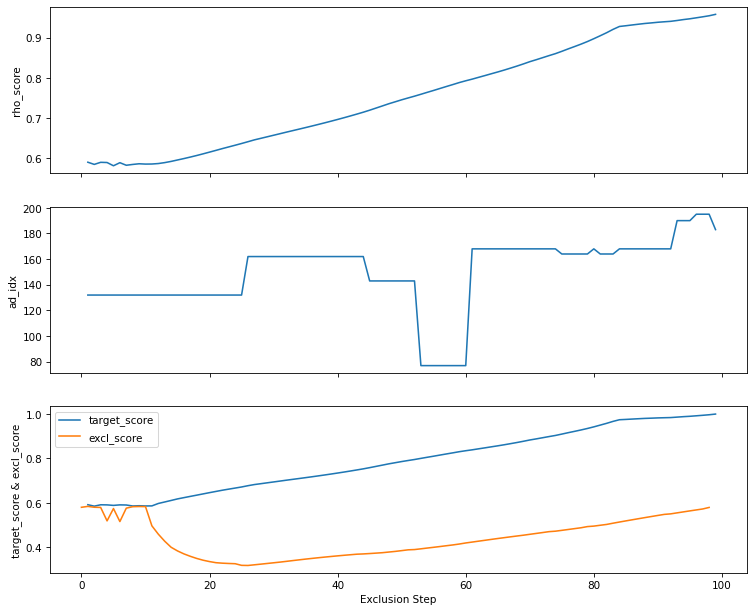

In [30]:
model.plot_results(
    use_fields=["rho_score", "ad_idx", ["target_score", "excl_score"]],  
    figsize=(12,10)
)

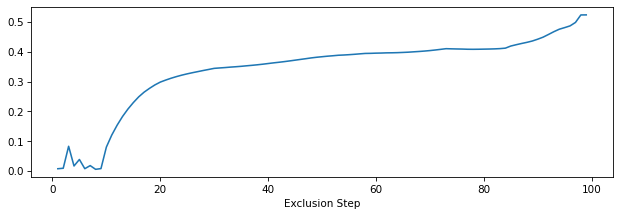

In [18]:
model.plot_calculated_fields([diff], figsize=(10, 3))

<h2>Exclusion Algorithm Weighted</h2>

<p>Previously we had equally weighted players. Let's change it this time and assign each player his own weight of priority.</p>

<h4>Weights</h4>
<p>Now every player has his own weight based on a number of parameters requested by advertiser. For example these might be things like prior conversion or metrics measuring how well we know preferences of a given player.</p>
<p>We will calculate each individual weight as a linear combination of various parameters that could be harvested through the recommendation system</p> 

$
Weight = \alpha \cdot conversion + \beta \cdot search\_history + \gamma \cdot commute\_regularity + \theta \cdot trip\_purpose
$

<h4>Weighted Rho-score calculation</h4>
<br>
$
    \rho_{score}^{(i)} = \frac{1}{\sum_{|Target\,/\,{X_j}|}w_j} \times \sum_{X_i\in{\,Target\,/\,{X_j}}} \left[w_i \cdot{\frac{<X_i\cdot A>}{<A\cdot A>}}\right] \cdot{\alpha}+ \frac{1}{\sum_{|Exclusion\,\cup{X_j}|}w_j} \times \sum_{X_i\in{\,Exclusion\,\cup{X_j}}}\left[w_i\cdot{\frac{<X_i\cdot A>}{<A\cdot A>}}\right]\cdot{(1-\alpha)} \rightarrow \max_{X_i, A}
$ </br>

<p>Now opinions are weighted therefore players with higher conversion and other desired parameters have the upper hand over others</p>

In [19]:
np.random.seed(120)

In [20]:
group = Group(n_players=100, n_topics=1000)

prefs = group.vertical_discrete_prefs(n_subgroups=20) # for some reason more volatile data
prefs

array([[1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 0, 0, ..., 1, 1, 0]])

In [21]:
group.create_random_weights()

In [22]:
# In order to use weighted algorithm just pass in weights to ExclusionAlgo or ExclusionConstrained

model = ExclusionConstrained(prefs, ads, group.weights)
model.fit()

IntProgress(value=1, min=1)

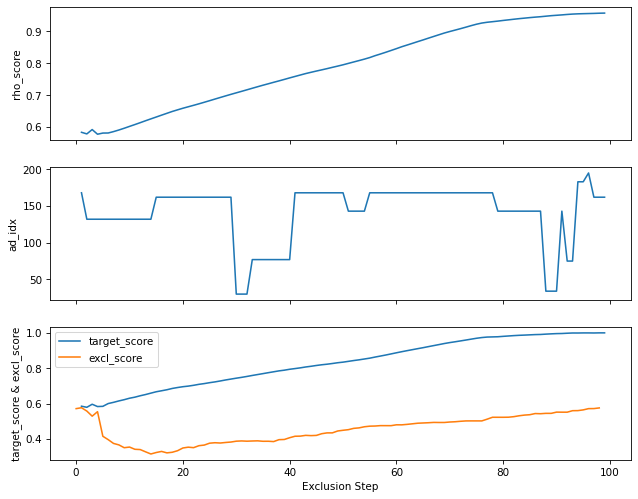

In [23]:
model.plot_results(
    use_fields=["rho_score", "ad_idx", ["target_score", "excl_score"]], 
    figsize=(10,8)
)

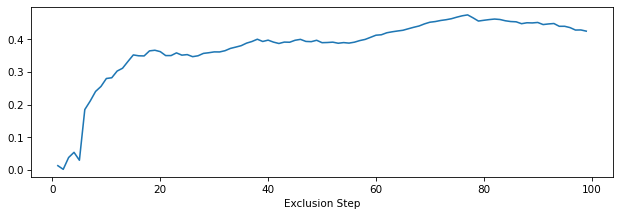

In [24]:
model.plot_calculated_fields([diff], figsize=(10, 3))

<h3>Results</h3>
<p>It is indeed difficult to say when we should stop exclusions. Rho score itself doesnt provide us with any information about how target and exclusion clusters evolve across exclusions. Rho score is only used to determine best person to exclude at each iteration. It is always the case that rho_score is highest at the very last exclusions as advertisement adapts to preferences of a small group of people. I propose using $argmin\,\,\rho_{exclusion}$ as a rule of thumb. Since exclusion set is supposed to be less prioritized, therefore it is logical to have their satisfaction lower. Other than that, if using $argmin \,\, \rho_{exclusion}$ we have the same optimal advertisement and the rho_score increases this simply means that we exclude people from target simply because their individual score is below the mean. This is unwanted behaviour as there is no adveretisement adjustment simply swapping element around to get the highest mean.</p>

In [25]:
stop_idx = np.array(model.results['excl_score']).argmin()
model.results['ad_idx'][stop_idx]

162

In [26]:
np.unique(np.array(model.results['ad_idx']))

array([ 30,  34,  75,  77, 132, 143, 162, 168, 183, 195])

In [27]:
dot_array = np.einsum("ij,ij->i", ads, ads)

res = np.sum(np.matmul(prefs, ads.T) / dot_array * group.weights, axis=0) / np.sum(group.weights)
res.argsort()[::-1]

array([132, 162, 143, 157, 103,  69,  30,  93,   8,  97,  60,  13,  51,
       171,  39, 168,  35, 176,  24,  26,  53,  56,  87, 137,  16,  92,
        19, 114,  95,  77,  21,  31,  10, 183,  33,  81,   0, 196,  38,
       128,  42, 167,  73, 148, 123, 188, 189, 153,  23, 107, 135,  44,
        63,  45, 136, 140, 174, 105, 147,  48, 195, 149,  94, 187,  55,
       170,  99, 165,  46, 161,  96,  75, 101, 113, 185, 150,  67,  62,
       173,   6,  72,  18, 131,   4, 154, 164, 104,  22, 160, 112, 146,
       152, 100, 163, 169,  15, 122,  29, 111, 197, 159,  65, 158, 126,
       116, 198,  47,  34,  14,  83, 134,   7,  54,  76,  79,  91,  82,
       125,  78, 138,   5,  50, 172, 191, 142, 118, 129,  43,  80, 182,
       181,   2, 199, 119, 117, 179, 130,  89,  25, 106,   3, 144,  41,
       177,  74,  66, 175,  57, 108, 178,  88,  58, 115,  12,  40,   1,
       180, 127,  27, 194,  68,  71,  59,  32,  61, 120,  90,  85,  64,
       166,  52,  11,  20, 139, 184, 151, 102, 124, 192,  98,  8